In [1]:
import os
import sys
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
from tifffile import tifffile
from matplotlib import pyplot as plt
from PIL import Image
from skimage.measure import label
from skimage.color import label2rgb
import cv2

from skimage.exposure import rescale_intensity
from skimage.segmentation import clear_border

from mnfinder import MNClassifier

# Loading a model and generating a prediction
Several different neural net predictors are available:

In [2]:
MNClassifier.get_available_models()

['Attention',
 'Attention96',
 'Combined',
 'LaplaceDeconstruction',
 'MNClassifier',
 'MSAttention',
 'MSAttention96']

Let’s try the `Attention` model, which is the default.

In [3]:
attention_model = MNClassifier.get_model('Attention')

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_91 (Conv2D)  │ (None, 128, 128,  │      1,216 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 128, 128,  │          0 │ conv2d_91[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_92 (Conv2D)  │ (None, 128, 128,  │     36,928 │ dropout_32[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 64, 64,    │          0 │ conv2d_92[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_93 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_17… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 64, 64,    │          0 │ conv2d_93[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 64, 64,    │    147,584 │ dropout_33[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 32, 32,    │          0 │ conv2d_94[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_18… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 32, 32,    │          0 │ conv2d_95[0][0]   │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 32, 32,    │    590,080 │ dropout_34[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 16, 16,    │          0 │ conv2d_96[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_19… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 16, 16,    │          0 │ conv2d_97[0][0]   │
│ (Dropout)           │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ dropout_35[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 8, 8, 512) │          0 │ conv2d_98[0][0] 

 Total params: 31,902,183 (121.70 MB)

 Trainable params: 31,902,183 (121.70 MB)

 Non-trainable params: 0 (0.00 B)

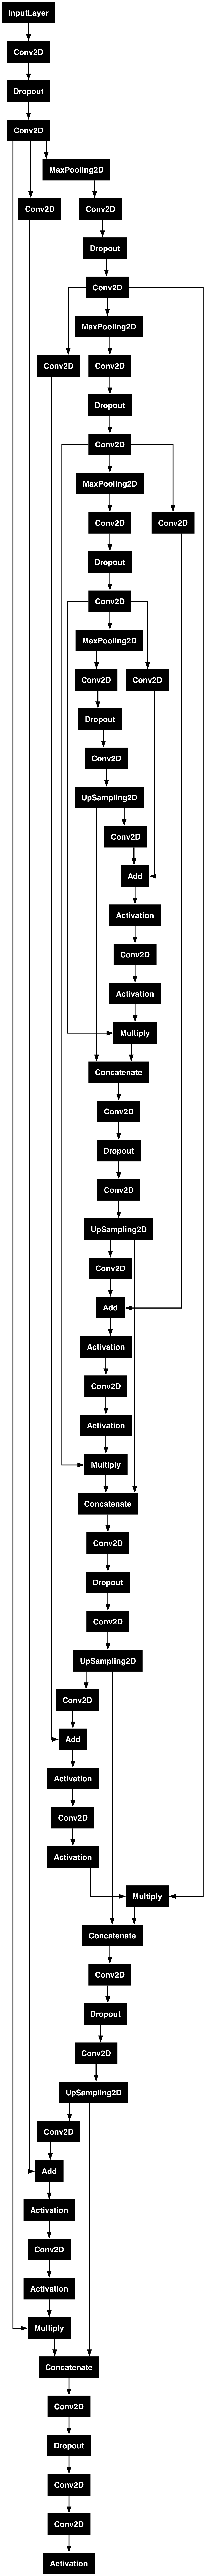

In [4]:
import tensorflow as tf
m = attention_model._build_model()
m.summary()
tf.keras.utils.plot_model(m)

Testing and training data are stored in the package and can be accessed via the `MNModel.testing_root` and `MNModel.training_root` paths.

The following image is of live U2 OS cells expressing H2B-emiRFP703 and NLS-3xDendra2, taken on a 20x widefield microscope.

In [5]:
img = tifffile.imread(MNClassifier.testing_root / "2022-10-14_U2OS/images/4.tif")
img.shape

(768, 869)

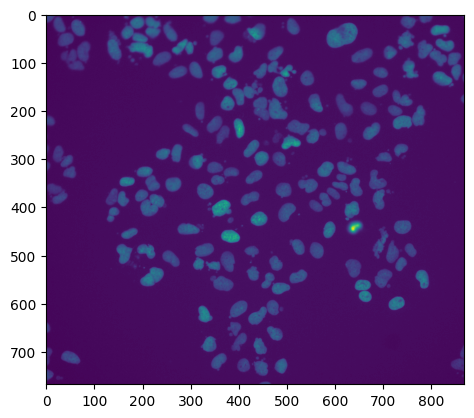

In [6]:
plt.imshow(img)

In [7]:
# Generate a prediction
# Images are expected to be 2D single-channel images, or with channels as the last argument
# in which case, only the first channel will be used
labels = attention_model.predict(img)

2024-05-10 17:19:01.895200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-10 17:19:24.513790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
nuc_labels = labels[...,0]
mn_labels = labels[...,2]
mn_assignments = labels[...,1]
labels.shape

(768, 869, 3)

## Prediction vs ground truth

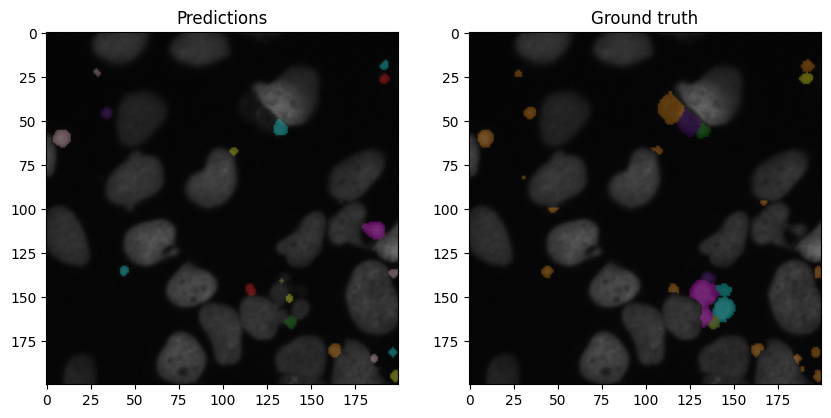

In [9]:
# Load ground truth
true_labels = np.array(Image.open(MNClassifier.testing_root / "2022-10-14_U2OS/mn_masks/4.png"))
true_labels = true_labels[...,1]

f,ax = plt.subplots(1,2, figsize=(10,10))
ax[0].set_title("Predictions")
ax[0].imshow(label2rgb(mn_labels, rescale_intensity(img))[0:200,300:500])
ax[1].set_title("Ground truth")
ax[1].imshow(label2rgb(true_labels, rescale_intensity(img))[0:200,300:500])

IOU: 45.67%
Proportion predictions overlapping with true masks: 75.07%
Proportion predictions not overlapping with true masks: 24.93%


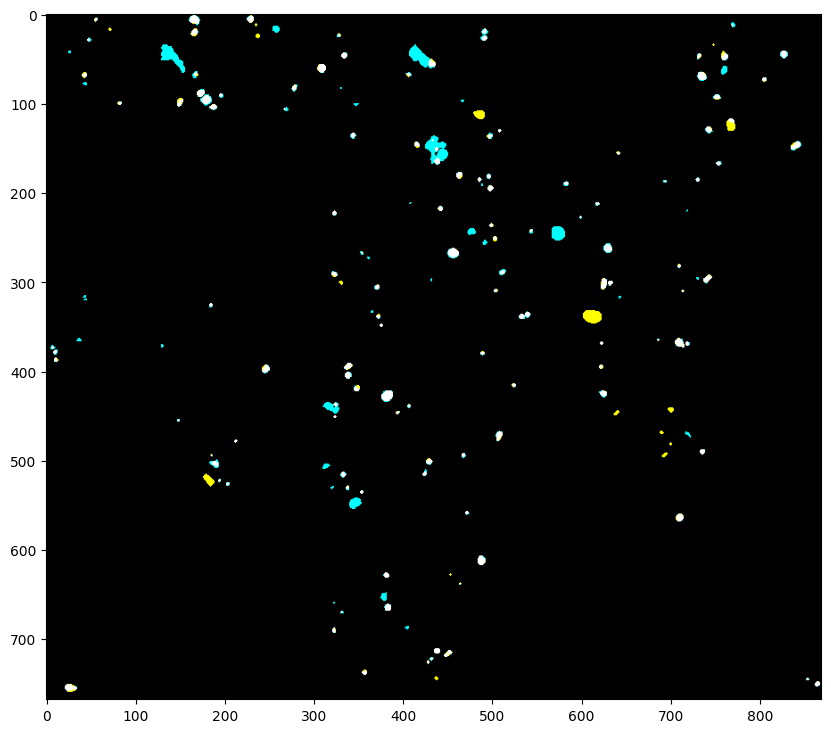

In [10]:
comparison = np.zeros(( img.shape[0], img.shape[1], 3), dtype=np.uint8)
comparison[(mn_labels > 0) & (true_labels <= 0)] = (255,255,0) # FP yellow
comparison[(mn_labels <= 0) & (true_labels > 0)] = (0,255,255) # FN blue
comparison[(mn_labels > 0) & (true_labels > 0)] = (255,255,255) # TP

f,ax = plt.subplots(1, figsize=(10,10))
ax.imshow(comparison)
intersection = np.sum((mn_labels > 0) & (true_labels > 0))/np.sum((mn_labels > 0))
divergent = np.sum((mn_labels > 0) & (true_labels <= 0))/np.sum((mn_labels > 0))
iou = np.sum((mn_labels > 0) & (true_labels > 0))/np.sum((mn_labels > 0) | (true_labels > 0))
print("IOU: {:.2f}%".format(iou*100))
print("Proportion predictions overlapping with true masks: {:.2f}%".format(intersection*100)) 
print("Proportion predictions not overlapping with true masks: {:.2f}%".format(divergent*100)) 

## Adjusting prediction parameters
MNFinder uses some post-processing to increase prediction accuracy, including binary opening and mask expansion. These steps can be skipped, if you wish.

2024-05-10 17:20:11.589532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-10 17:20:34.777998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


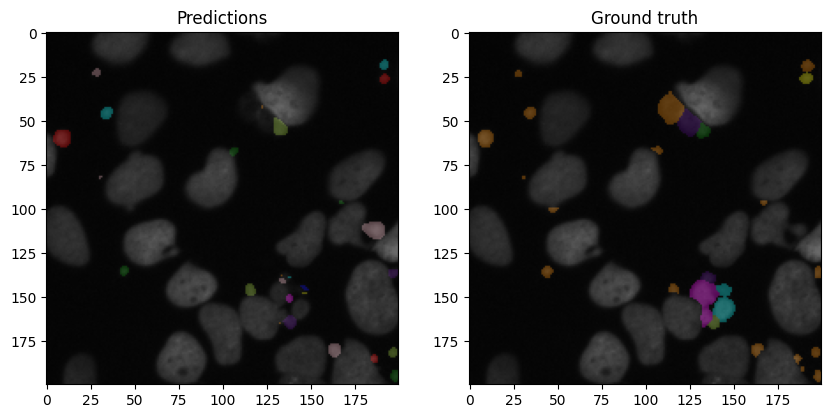

In [11]:
labels = attention_model.predict(img, skip_opening=True)
mn_labels = labels[...,2]

f,ax = plt.subplots(1,2, figsize=(10,10))
ax[0].set_title("Predictions")
ax[0].imshow(label2rgb(mn_labels, rescale_intensity(img))[0:200,300:500])
ax[1].set_title("Ground truth")
ax[1].imshow(label2rgb(true_labels, rescale_intensity(img))[0:200,300:500])

IOU: 47.71%
Proportion predictions overlapping with true masks: 73.00%
Proportion predictions not overlapping with true masks: 27.00%


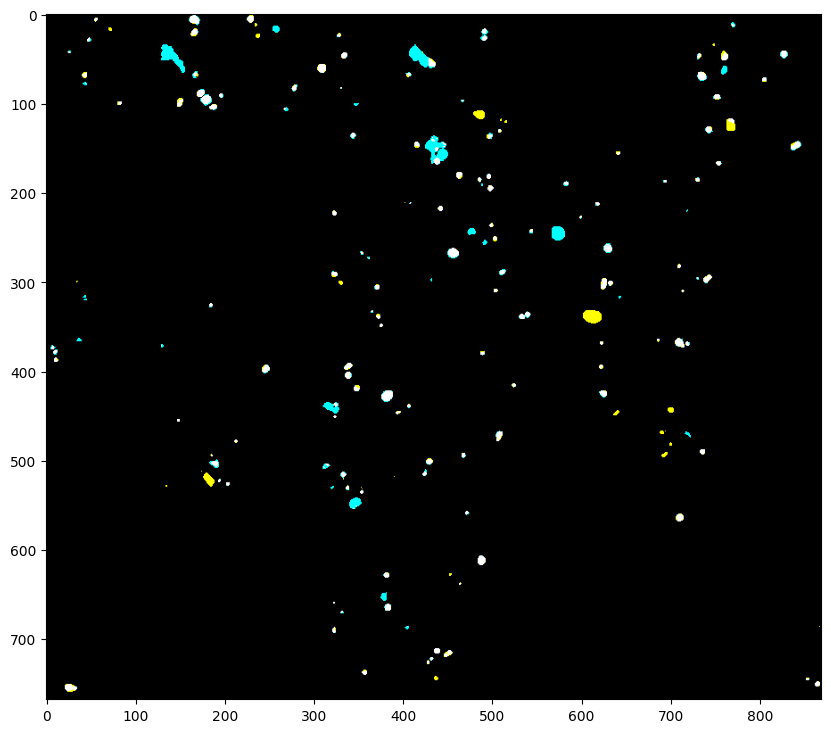

In [12]:
comparison = np.zeros(( img.shape[0], img.shape[1], 3), dtype=np.uint8)
comparison[(mn_labels > 0) & (true_labels <= 0)] = (255,255,0) # FP yellow
comparison[(mn_labels <= 0) & (true_labels > 0)] = (0,255,255) # FN blue
comparison[(mn_labels > 0) & (true_labels > 0)] = (255,255,255) # TP

f,ax = plt.subplots(1, figsize=(10,10))
ax.imshow(comparison)
intersection = np.sum((mn_labels > 0) & (true_labels > 0))/np.sum((mn_labels > 0))
divergent = np.sum((mn_labels > 0) & (true_labels <= 0))/np.sum((mn_labels > 0))
iou = np.sum((mn_labels > 0) & (true_labels > 0))/np.sum((mn_labels > 0) | (true_labels > 0))
print("IOU: {:.2f}%".format(iou*100))
print("Proportion predictions overlapping with true masks: {:.2f}%".format(intersection*100)) 
print("Proportion predictions not overlapping with true masks: {:.2f}%".format(divergent*100)) 

## Images at higher resolutions
Models were trained on images taken on a 20x objective. Images taken at other resolutions should be rescaled for optimal results.

This image is of fixed RPE-1 cells expressing 2xRFP-NLS and stained with DAPI, originally taken on a 40x confocal objective. It has already been scaled down by a factor of 2:

In [13]:
img = tifffile.imread(MNClassifier.testing_root / "2023-05-31_misc/images/MAX_2022-12-29 ATF3 tilescan.lif - BAY.tif")
img.shape

(512, 512)

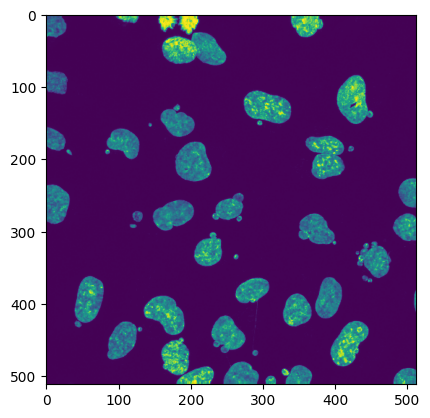

In [14]:
plt.imshow(img)

In [15]:
# Load ground truth
true_labels = np.array(Image.open(MNClassifier.testing_root / "2023-05-31_misc/mn_masks/MAX_2022-12-29 ATF3 tilescan.lif - BAY.png"))
true_labels = true_labels[...,2]

2024-05-10 17:21:05.529313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-10 17:21:12.227290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


IOU: 57.18%
Proportion predictions overlapping with true masks: 85.80%
Proportion predictions not overlapping with true masks: 14.20%


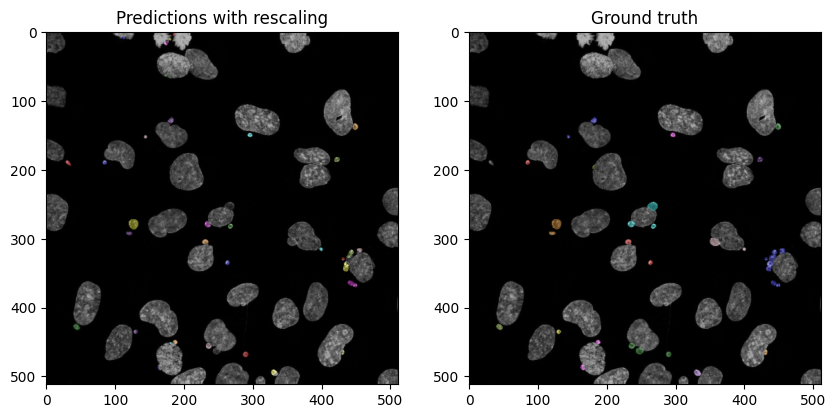

In [16]:
labels = attention_model.predict(img)
mn_labels = labels[...,2]

f,ax = plt.subplots(1,2, figsize=(10,10))
ax[0].set_title("Predictions with rescaling")
ax[0].imshow(label2rgb(mn_labels, rescale_intensity(img)))
ax[1].set_title("Ground truth")
ax[1].imshow(label2rgb(true_labels, rescale_intensity(img)))

intersection = np.sum((mn_labels > 0) & (true_labels > 0))/np.sum((mn_labels > 0))
divergent = np.sum((mn_labels > 0) & (true_labels <= 0))/np.sum((mn_labels > 0))
iou = np.sum((mn_labels > 0) & (true_labels > 0))/np.sum((mn_labels > 0) | (true_labels > 0))
print("IOU: {:.2f}%".format(iou*100))
print("Proportion predictions overlapping with true masks: {:.2f}%".format(intersection*100)) 
print("Proportion predictions not overlapping with true masks: {:.2f}%".format(divergent*100)) 

If we scale the image back up to its original size and try again, we can see the change in performance:

2024-05-10 17:21:22.453475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-10 17:21:48.178092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


IOU: 20.93%
Proportion predictions overlapping with true masks: 78.05%
Proportion predictions not overlapping with true masks: 21.95%


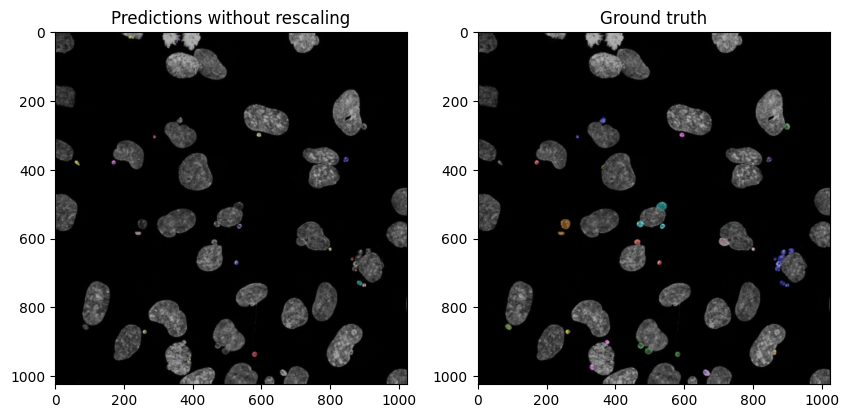

In [17]:
# Original image size
resized_img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_NEAREST)
resized_true_labels = cv2.resize(true_labels, None, fx=2, fy=2, interpolation=cv2.INTER_NEAREST)

labels = attention_model.predict(resized_img)
mn_labels = labels[...,2]
f,ax = plt.subplots(1,2, figsize=(10,10))
ax[0].set_title("Predictions without rescaling")
ax[0].imshow(label2rgb(mn_labels, rescale_intensity(resized_img)))
ax[1].set_title("Ground truth")
ax[1].imshow(label2rgb(resized_true_labels, rescale_intensity(resized_img)))

intersection = np.sum((mn_labels > 0) & (resized_true_labels > 0))/np.sum((mn_labels > 0))
divergent = np.sum((mn_labels > 0) & (resized_true_labels <= 0))/np.sum((mn_labels > 0))
iou = np.sum((mn_labels > 0) & (resized_true_labels > 0))/np.sum((mn_labels > 0) | (resized_true_labels > 0))
print("IOU: {:.2f}%".format(iou*100))
print("Proportion predictions overlapping with true masks: {:.2f}%".format(intersection*100)) 
print("Proportion predictions not overlapping with true masks: {:.2f}%".format(divergent*100)) 

mIOU: 20.87%
Proportion predictions overlapping with true masks: 78.05%
Proportion predictions not overlapping with true masks: 21.95%


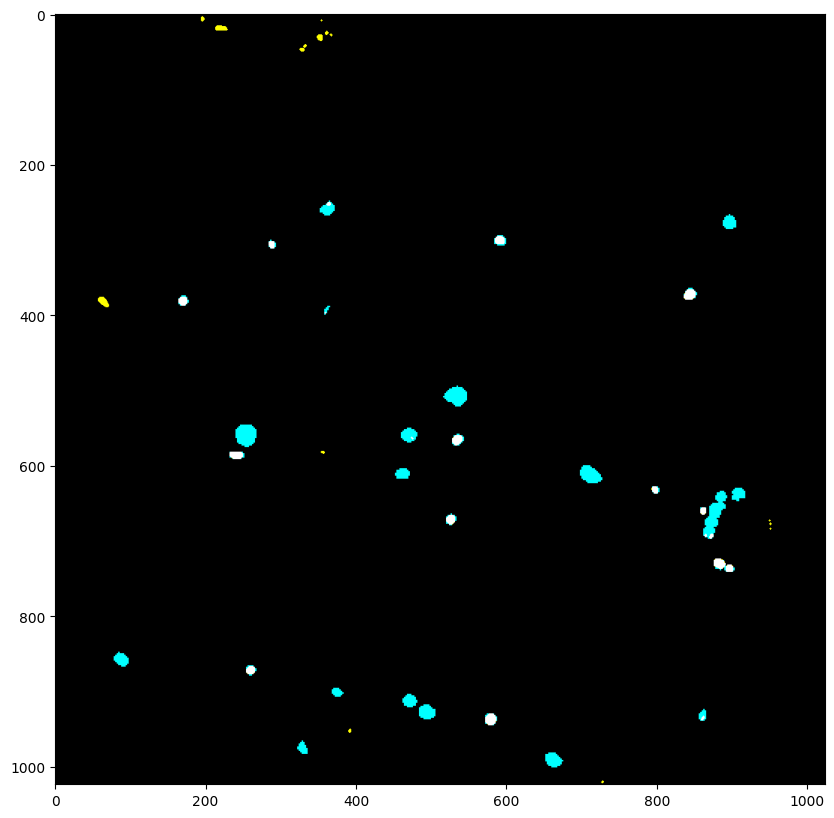

In [34]:
comparison = np.zeros(( resized_img.shape[0], resized_img.shape[1], 3), dtype=np.uint8)
comparison[(mn_labels > 0) & (resized_true_labels <= 0)] = (255,255,0) # FP yellow
comparison[(mn_labels <= 0) & (resized_true_labels > 0)] = (0,255,255) # FN blue
comparison[(mn_labels > 0) & (resized_true_labels > 0)] = (255,255,255) # TP

f,ax = plt.subplots(1, figsize=(10,10))
ax.imshow(comparison)
intersection = np.sum((mn_labels > 0) & (resized_true_labels > 0))/np.sum((mn_labels > 0))
divergent = np.sum((mn_labels > 0) & (resized_true_labels <= 0))/np.sum((mn_labels > 0))
iou = np.sum((mn_labels > 0) & (resized_true_labels > 0))/np.sum((mn_labels > 0) | (resized_true_labels > 0))
print("mIOU: {:.2f}%".format(iou*100))
print("Proportion predictions overlapping with true masks: {:.2f}%".format(intersection*100)) 
print("Proportion predictions not overlapping with true masks: {:.2f}%".format(divergent*100)) 

## Nucleus masks and MN assignment
Nuclei are segmented and associated MN assigned to them, which can be access in the first and second channels of labels:

2024-05-10 16:43:14.384500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-10 16:43:55.358651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Text(0.5, 1.0, 'Nuclei with associated MN')

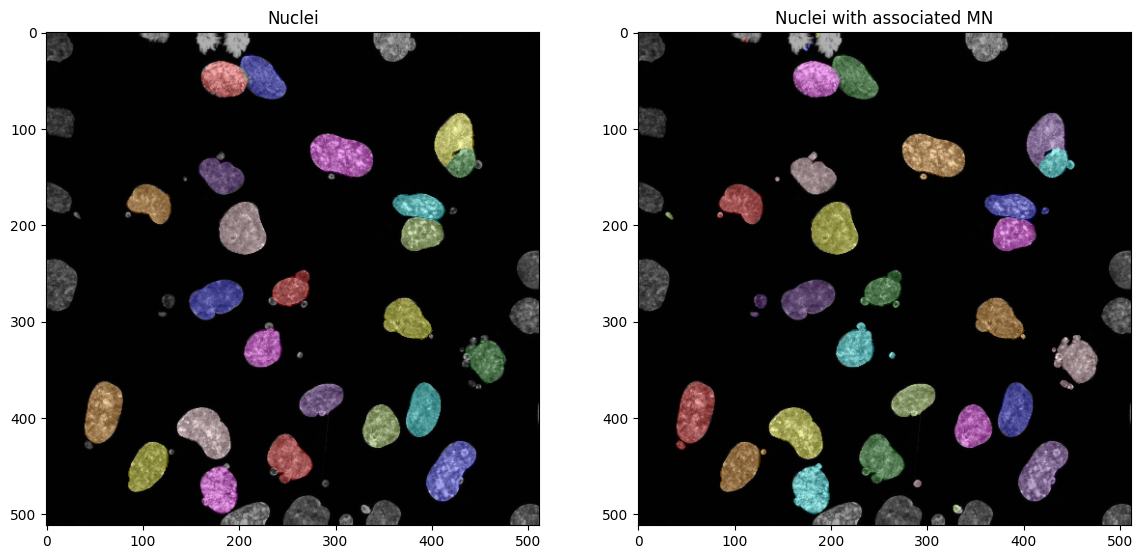

In [43]:
labels = attention_model.predict(img)
f,ax = plt.subplots(1,2, figsize=(14,10))
ax[0].imshow(label2rgb(labels[...,0], img))
ax[0].set_title("Nuclei")
ax[1].imshow(label2rgb((labels[...,0]+labels[...,1]), img))
ax[1].set_title("Nuclei with associated MN")

## Retraining models
You may find training on your data set improves predictions for your use cases.

New training data should be structured as follows:
````
path/to/training-data/
    data-set1/
        images/
            img1.tiff
            ...
        mn_masks/
            img1.png
            ...
        nucleus_masks/
            img1.png
            ...
    data-set2/
        images/
            different-img.TIF
            ...
        mn_masks/
            different-img.png
            ...
        nucleus_masks/
            different-img.png
            ...
    ...
````

Validation data should be structured similarly.

Micronucleus and nucleus masks should be 3-channel images. Nuclei should have the 3rd channel correspond to unique labels for each nucleus. Micronucleus masks should share the same label as their associated nucleus; the first 2 channels can be used to separate micronuclei that are touching and belong to the same cell.

For example, you may label a nucleus in the nucleus mask [255,255,1]. All corresponding MN would be labelled [*,*,1], where the asterisks can be any value.

Images can be single- or multi-channel images. For multi-channel images, only the first channel will be used.    

If `save_weights` is `True` and no alternative save path is provided by the `save_path` argument, the new weights will replace the weights that come with this package. 


In [50]:
m, history = attention_model.train(
    train_path=MNClassifier.training_root, 
    val_path=MNClassifier.validation_root, 
    save_weights=False,
    epochs=1
)

[autoreload of mnfinder.mnfinder failed: Traceback (most recent call last):
  File "/Volumes/T7/new_NN/test_env/.env/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Volumes/T7/new_NN/test_env/.env/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Volumes/T7/new_NN/test_env/.env/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Volumes/T7/new_NN/test_env/.env/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Volumes/T7/new_NN/test_env/.env/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Volumes/T7/new_NN/test_env/.env/lib/python3.12/site-packages/IPytho

Located 7 directories...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 616.91it/s]


Located 3 directories...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1203.30it/s]


   3/5400 ━━━━━━━━━━━━━━━━━━━━ 18:54:17 13s/step - accuracy: 0.5091 - dice_coef: 0.0589 - loss: 0.3048 - mean_iou: 0.0018 - mean_iou_with_nuc: 0.0307 - sigmoid_focal_crossentropy: 0.3048 - sigmoid_focal_crossentropy_loss: 0.3048  

KeyboardInterrupt: 

In [49]:
df = history.history.copy()
df['epoch'] = history.epoch
df = pd.DataFrame(df)
df

,loss,sigmoid_focal_crossentropy_loss,sigmoid_focal_crossentropy,mean_iou,mean_iou_with_nuc,accuracy,val_loss,val_sigmoid_focal_crossentropy_loss,val_sigmoid_focal_crossentropy,val_mean_iou,val_mean_iou_with_nuc,val_accuracy,lr,epoch
0,0.069302,0.069302,0.069302,0.029405,0.165866,0.904672,0.052629,0.052629,0.052629,0.04606,0.263545,0.899729,0.0005,0


In [61]:
new_attention_model = MNClassifier.get_model('Attention', trained_model=m)

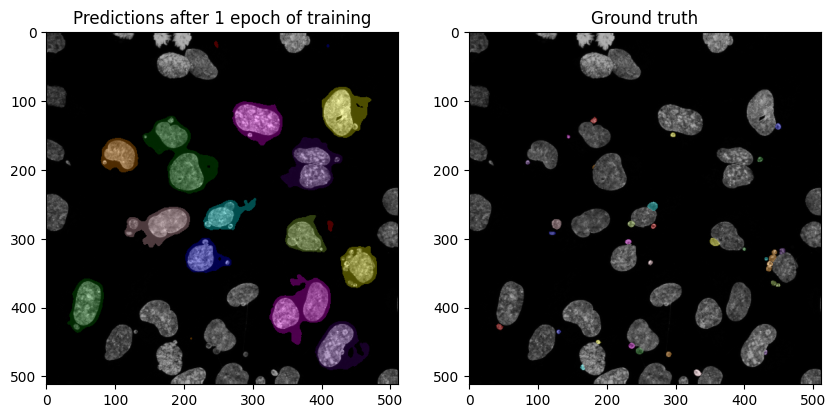

In [66]:
labels = new_attention_model.predict(img)
f,ax = plt.subplots(1,2, figsize=(14,10))
ax[0].imshow(label2rgb(labels[...,0], img))
ax[0].set_title("Nuclei")
ax[1].imshow(label2rgb((labels[...,0]+labels[...,1]), img))
ax[1].set_title("Nuclei with associated MN")

## Evaluating predictions
MNFinder can evaluate predictions based on ground truth masks

In [22]:
mn_mask_path = (MNClassifier.testing_root / "mn_masks/MAX_2022-12-29 ATF3 tilescan.lif - BAY.png")
nucleus_mask_path = (MNClassifier.testing_root / "nucleus_masks/MAX_2022-12-29 ATF3 tilescan.lif - BAY.png")
mn_mask = np.asarray(Image.open(mn_mask_path))
nucleus_mask = np.asarray(Image.open(nucleus_mask_path))

ground_truth = TrainingDataGenerator.get_full_mask(nucleus_mask, mn_mask)
mn_df, nuc_df, pred_mn_df, pred_nuc_df, summary_df = MNClassifier.eval_mn_prediction(full_mask, labels)

### Micronucleus information
**`mn_id`**
: The unique ID of this micronucleus

**`cell_id`**
: The unique ID of cell to which this micronucleus belongs

**`intact`**
: Whether this MN is intact or not (not implemented)

**`found`**
: If at least one pixel overlaps with a prediction

**`area`**
: The area of the micronucleus in square pixels

**`proportion_segmented`**
: The proportion of this micronucleus that overlaps with one or more predictions

**`pred_labels`**
: The label(s) of the prediction that overlaps with this micronucleus

**`pred_cell_labels`**
: The label(s) of the cell predictions that are associated with this MN

In [23]:
mn_df

,true_mn_label,intact,found,area,proportion_segmented,pred_labels
0,1,True,True,65,0.938462,[6]
1,2,True,True,69,0.840580,[7]
2,3,True,True,47,0.765957,[8]
3,4,True,True,23,0.913043,[9]
4,5,True,True,53,0.886792,[10]
5,6,True,True,38,0.789474,[12]
6,7,True,False,12,0.000000,[]
7,8,True,False,149,0.000000,[]
8,9,True,False,170,0.000000,[]
9,10,True,True,81,0.629630,[13]


### Nucleus information
**`cell_id`**
: The unique ID of cell to which this micronucleus belongs

**`found`**
: If at least one pixel overlaps with a prediction

**`area`**
: The area of the nucleus in square pixels

**`proportion_segmented`**
: The proportion of this nucleus that overlaps with one or more predictions

**`pred_labels`**
: The label(s) of the prediction that overlaps with this nucleus

In [ ]:
nuc_df

### MN prediction information
**`mn_label`**
: The unique label of this prediction

**`cell_label`**
: The unique label of cell label to which this prediction is associated

**`exists`**
: If at least one pixel overlaps with a true micronucleus

**`area`**
: The area of the prediction in square pixels

**`proportion_true`**
: The proportion of this prediction that overlaps with one or more micronuclei

**`true_ids`**
: The ID(s) of the micronucleus that overlaps with this prediction

**`correctly_assigned`**
: If this MN is assigned to the correct nucleus

In [24]:
pred_mn_df

,pred_mn_label,exists,area,proportion_true,true_labels
0,1,False,20,0.000000,[]
1,2,False,18,0.000000,[]
2,3,False,10,0.000000,[]
3,4,False,28,0.000000,[]
4,5,False,12,0.000000,[]
5,6,True,65,0.938462,[1]
6,7,True,61,0.950820,[2]
7,8,True,36,1.000000,[3]
8,9,True,21,1.000000,[4]
9,10,True,48,0.979167,[5]


### Nucleus prediction information
**`cell_label`**
: The unique label of this cell prediction

**`exists`**
: If at least one pixel overlaps with a true nucleus

**`area`**
: The area of the prediction in square pixels

**`proportion_true`**
: The proportion of this prediction that overlaps with one or more nuclei

**`true_ids`**
: The ID(s) of the nucleus that overlaps with this prediction

In [ ]:
pred_nuc_df

### Summary statistics
**`num_mn`**
: The number of micronuclei in this field

**`num_nuclei`**
: The number of nuclei in this field

**`num_intact_mn`/`num_ruptured_mn`**
: The number of intact and ruptured micronuclei in this field (if any distinction was made)

**`num_mn_predictions`**
: The number of micronucleus predictions

**`num_nuclei_predictions`**
: The number of nucleus predictions

**`num_mn_found`/`num_intact_mn_found`/`num_ruptured_mn_found`**
: The number of micronuclei that overlap with a prediction

**`mn_iou`**
: IoU describes the intersection of micronucleus and prediction pixels / the union of the same

**`nuclei_iou`**
: IoU describes the intersection of nucleus and prediction pixels / the union of the same

**`combined_iou`**
: IoU of nucleus and micronucleus predictions

**`mn_intersection`**
: The number of pixels that overlap between micronuclei and predictions

**`nuclei_intersection`**
: The number of pixels that overlap between nuclei and predictions

**`combined_intersection`**
: The number of pixels that overlap between nuclei and micronuclei and their predictions

**`mn_divergence`**
: The number of prediction pixels that do not overlap with true micronuclei

**`nuclei_divergence`**
: The number of prediction pixels that do not overlap with true nuclei

**`combined_divergence`**
: The number of prediction pixels that do not overlap with true micronuclei or nuclei

**`mn_ppv`**
: The proportion of predictions that overlap with true micronuclei

**`nuclei_ppv`**
: The proportion of predictions that overlap with true nuclei

**`mn_recall`/`intact_recall`/`ruptured_recall`**
: The proportion of micronuclei that overlap with predictions

**`nuclei_recall`**
: The proportion of nuclei that overlap with predictions

In [25]:
summary_df

,num_mn,num_intact_mn,num_ruptured_mn,num_predictions,num_mn_found,num_intact_mn_found,num_ruptured_mn_found,iou,intersection,divergence,ppv,recall,intact_recall,ruptured_recall
0,29,29,0,31,23,23,0,0.491909,1064,188,0.741935,0.793103,0.793103,NaN


(0.0, 1.2)

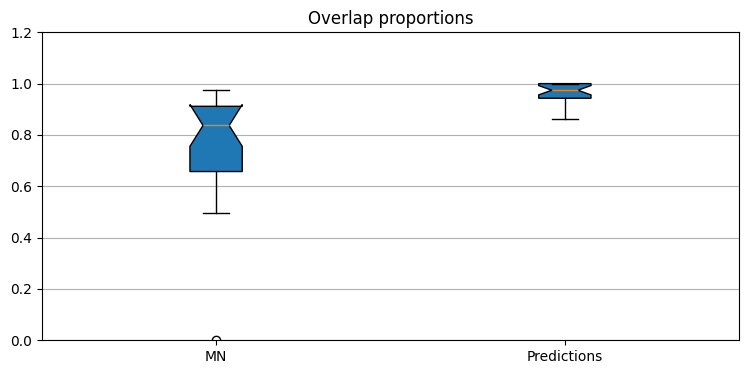

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

# Equalize number of prediction and true segment arrays
found_mn = mn_df['proportion_segmented'].loc[mn_df['found']]
true_pred = pred_df['proportion_true'].loc[pred_df['exists']]
longest = np.max([ len(found_mn), len(true_pred) ])
mn_pad = longest-len(found_mn)
pred_pad = longest-len(true_pred)
all_data = [ 
    np.pad(found_mn, (0,mn_pad), 'empty'), 
    np.pad(true_pred, (0,pred_pad), 'empty')
]

bplot2 = ax.boxplot(all_data,
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['MN','Predictions'])  # will be used to label x-ticks
ax.set_title('Overlap proportions')
ax.yaxis.grid(True)
ax.set_ylim(0,1.2)